MLP Test;n = 9, 12

In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score

# 실험할 n 및 e 값 설정
possible_n_vals = [9, 12, 15, 18, 24, 30]
possible_e_vals = [1, 2]

# 성능 결과를 저장할 리스트
val_accuracies = []
test_accuracies = []
feature_counts = []

# MLP 모델 정의
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, num_classes)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    print("usingGPU")
else:
    print("CPU")
for n in possible_n_vals:
    single_val_accuracies = []
    single_test_accuracies = []
    single_feature_counts = []
    
    for e in possible_e_vals:
        # 데이터셋 로드
        X = np.load(f'../Datasets/kryptonite-{n}-X.npy')
        y = np.load(f'../Datasets/kryptonite-{n}-y.npy')

        # 데이터셋을 60% 훈련, 20% 검증, 20% 테스트로 분할
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

        # 다항식 특징 생성
        poly = PolynomialFeatures(degree=e)
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)
        X_test_poly = poly.transform(X_test)

        # 텐서로 변환
        X_train_tensor = torch.tensor(X_train_poly, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
        X_val_tensor = torch.tensor(X_val_poly, dtype=torch.float32).to(device)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
        X_test_tensor = torch.tensor(X_test_poly, dtype=torch.float32).to(device)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

        # 모델 초기화
        model = MLP(input_size=X_train_poly.shape[1], num_classes=len(np.unique(y))).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # 학습
        epochs = 10
        batch_size = 32
        for epoch in range(epochs):
            model.train()
            permutation = torch.randperm(X_train_tensor.size(0))
            for i in range(0, X_train_tensor.size(0), batch_size):
                indices = permutation[i:i+batch_size]
                batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]
                
                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

        # 검증 데이터 평가
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_predictions = torch.argmax(val_outputs, dim=1)
            val_accuracy = accuracy_score(y_val, val_predictions.cpu())
            
            test_outputs = model(X_test_tensor)
            test_predictions = torch.argmax(test_outputs, dim=1)
            test_accuracy = accuracy_score(y_test, test_predictions.cpu())
        
        # 생성된 특징 수 계산
        features = X_train_poly.shape[1]
        
        single_val_accuracies.append(val_accuracy)
        single_test_accuracies.append(test_accuracy)
        single_feature_counts.append(features)
        
        print(f"n={n}, e={e}, Validation Accuracy={val_accuracy:.4f}, Test Accuracy={test_accuracy:.4f}")

    # 각 n에 대해 성능과 특징 수 저장
    val_accuracies.append(single_val_accuracies)
    test_accuracies.append(single_test_accuracies)
    feature_counts.append(single_feature_counts)

# 최종 결과 출력
print("Validation Accuracies by n and e:", val_accuracies)
print("Test Accuracies by n and e:", test_accuracies)
print("Feature Counts by n and e:", feature_counts)


CPU
n=9, e=1, Validation Accuracy=0.9603, Test Accuracy=0.9578
n=9, e=2, Validation Accuracy=0.9589, Test Accuracy=0.9567
n=12, e=1, Validation Accuracy=0.9331, Test Accuracy=0.9323
n=12, e=2, Validation Accuracy=0.9219, Test Accuracy=0.9300
n=15, e=1, Validation Accuracy=0.7997, Test Accuracy=0.8033
n=15, e=2, Validation Accuracy=0.5240, Test Accuracy=0.5263
n=18, e=1, Validation Accuracy=0.5025, Test Accuracy=0.5039
n=18, e=2, Validation Accuracy=0.4915, Test Accuracy=0.5058
n=24, e=1, Validation Accuracy=0.5041, Test Accuracy=0.5002
n=24, e=2, Validation Accuracy=0.4974, Test Accuracy=0.5005
n=30, e=1, Validation Accuracy=0.5029, Test Accuracy=0.5052
n=30, e=2, Validation Accuracy=0.5021, Test Accuracy=0.5057
Validation Accuracies by n and e: [[0.9602777777777778, 0.9588888888888889], [0.933125, 0.921875], [0.7996666666666666, 0.524], [0.5025, 0.4915277777777778], [0.5040625, 0.4973958333333333], [0.5029166666666667, 0.5020833333333333]]
Test Accuracies by n and e: [[0.9577777777777

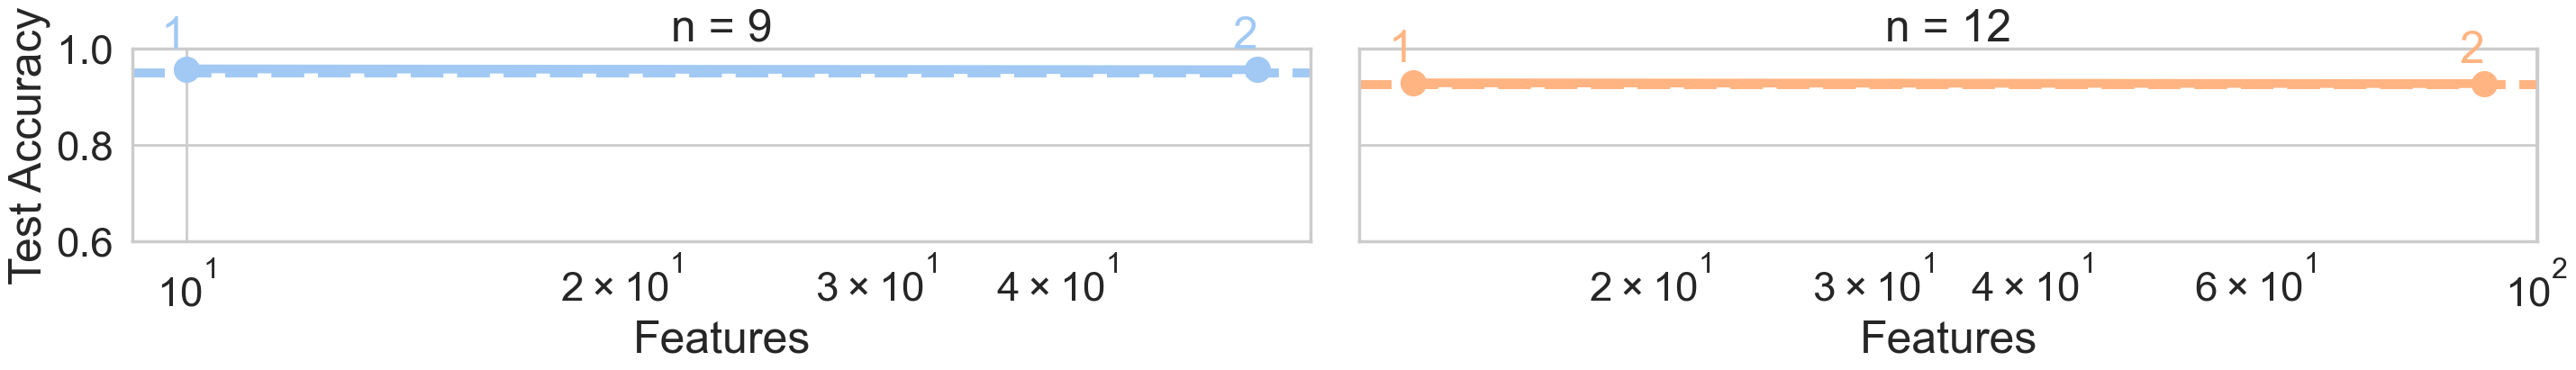

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data
n_values = [9, 12]  # 각 데이터셋 차원
p_values = [1, 2]  # 다항식 차수 e 값
feat_by_n = feature_counts  # 코드 실행 결과에서 얻은 특징 수
test_acc_by_n = test_accuracies 

# Plot style
sns.set(style="whitegrid")
sns.set_context("poster", font_scale=1.5)
colors = sns.color_palette("pastel", len(n_values))  # Pastel color palette

# 기준 정확도 선
success_hlines = [0.95, 0.925, 0.9]  # 각 n에 대한 기준 정확도

# Create subplots
fig, axes = plt.subplots(1, len(n_values), figsize=(30, 10), sharey=True)

# Plot each n-value in its own subplot
for i, (n, ax) in enumerate(zip(n_values, axes)):
    # 각 n에 대해 특징 수와 테스트 정확도 그래프 생성
    ax.plot(feat_by_n[i], test_acc_by_n[i], marker='o', label=f'n = {n}', color=colors[i],
            lw=7, markersize=20)
    
    # p-values에 따라 주석 추가
    for j, (x, y) in enumerate(zip(feat_by_n[i], test_acc_by_n[i])):
        ax.text(x, y + 0.025, f'{p_values[j]}', ha='right', va='bottom', color=colors[i])
        ax.axhline(success_hlines[i], color=colors[i], linestyle='--', lw=7)
    
    # Subplot 커스터마이징
    ax.set_title(f'n = {n}')
    ax.set_xlabel("Features")
    if i == 0:
        ax.set_ylabel("Test Accuracy")
    ax.set_xscale('log')  # x축 로그 스케일

# 레이아웃 조정 및 그래프 표시
plt.tight_layout()
plt.ylim((0.6, 1.0))  # y축 범위 설정
plt.show()


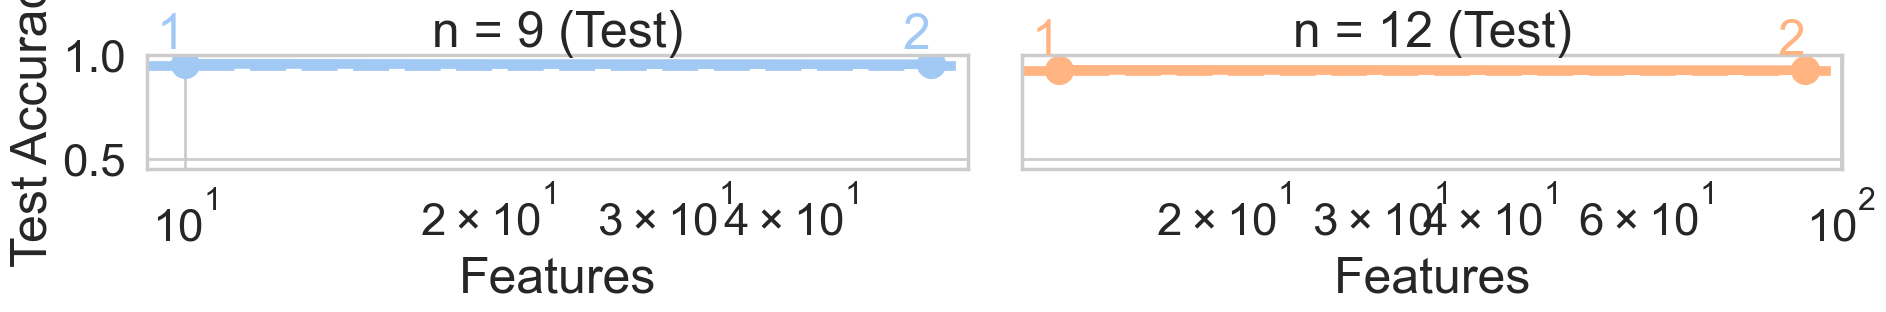